This notebook will consist of some experiments seeing how KANs perform with a scaffold split vs a regular test split. The basic idea of a scaffold split is to ensure that there are no two molecules the train and test sets respectively that have the same molecular scaffold. The reasoning for doing this is that molecules with the same scaffold tend to have similar molecular properties, and therefore it becomes possible for the model (especially large neural nets) to simply memorize a lookup table of molecular scaffolds and their corresponding properties. 

In [5]:
options = {
    'random_seed': 1738,
    'device': 'cpu',
    'test_size': 0.2,
    'n_training_steps': 100,
}

print(options)

{'random_seed': 1738, 'device': 'cpu', 'test_size': 0.2, 'n_training_steps': 100}


In [6]:
import sys
sys.path.append('../..')

In [7]:
import numpy as np
import torch
import polars as pl
import matplotlib.pyplot as plt

import rdkit
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles


from utils.data_utils import get_all_descriptors_from_smiles_list
from utils.evaluation_utils import regression_report

In [8]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pl.read_csv(filepath)

# get list of smiles strings
smiles_list = list(df_delaney['SMILES'])

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_polars=True)

Calculating descriptors: 100%|██████████| 1144/1144 [00:04<00:00, 273.37it/s]


In [9]:
descriptors_df.head()

MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,…,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5.116512,5.116512,0.039352,-1.276235,0.487138,12.0,167.85,165.834,165.891061,38.0,0.0,0.203436,-0.122063,0.203436,0.122063,1.166667,1.333333,1.333333,35.582798,10.92878,2.155416,-2.003515,2.259665,-2.010232,6.690915,1.27955,1.351644,3.16849,35.302969,5.207107,2.718965,5.74268,2.56066,1.187761,2.856177,0.748808,3.532139,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.060957,5.060957,1.083333,-1.083333,0.445171,12.0,133.405,130.381,131.930033,32.0,0.0,0.187382,-0.084013,0.187382,0.084013,1.2,1.2,1.2,35.582513,10.948044,2.065641,-1.94269,2.228454,-1.870955,6.667091,1.268178,0.721928,3.023716,20.364528,4.5,2.633893,4.90168,2.0,1.066947,2.20084,0.781232,3.629412,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.114198,5.114198,0.67284,-0.67284,0.527312,11.0,167.85,165.834,165.891061,38.0,0.0,0.137344,-0.102365,0.137344,0.102365,0.666667,0.833333,0.833333,35.544933,10.929605,2.063775,-1.94593,2.160253,-1.959015,6.563502,1.293168,1.360964,2.993497,26.529325,5.154701,2.666558,5.690274,2.642734,1.206205,2.951948,0.66891,2.996473,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.095679,5.095679,0.308642,-0.405864,0.480258,9.6,133.405,130.381,131.930033,32.0,0.0,0.120829,-0.123772,0.123772,0.120829,1.4,1.6,1.6,35.539546,10.949696,1.882355,-1.820706,2.007265,-1.820631,6.469236,1.398333,1.378783,2.539539,18.854753,4.284457,2.41835,4.686137,2.270056,1.111945,2.519339,0.545389,2.131038,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11.544753,11.544753,3.685957,-4.22608,0.553756,14.25,187.375,187.375,185.901768,50.0,0.0,0.382976,-0.199489,0.382976,0.199489,0.875,1.0,1.0,35.539783,10.767629,2.506738,-2.131584,2.420075,-2.268487,6.509766,0.024089,1.253298,4.020392,67.509775,7.0,3.267787,5.535574,3.25,1.383893,2.517787,0.995518,2.705322,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
scaffolds = pl.Series(name='Saffold_SMILES', values=[MurckoScaffoldSmilesFromSmiles(smi) for smi in smiles_list])
scaffolds = scaffolds.replace("", "No_Scaffold")
scaffolds.value_counts(sort=True)

Saffold_SMILES,count
str,u32
"""No_Scaffold""",318
"""c1ccccc1""",259
"""c1ccc(-c2ccccc2)cc1""",43
"""c1ccc2ccccc2c1""",22
"""O=C1CC(=O)NC(=O)N1""",21
…,…
"""c1ccc2nc(N3CCNCC3)ncc2c1""",1
"""c1ccc2c(c1)c1ccccc1c1ccccc21""",1
"""c1ncc2ccn(C3CCCO3)c2n1""",1


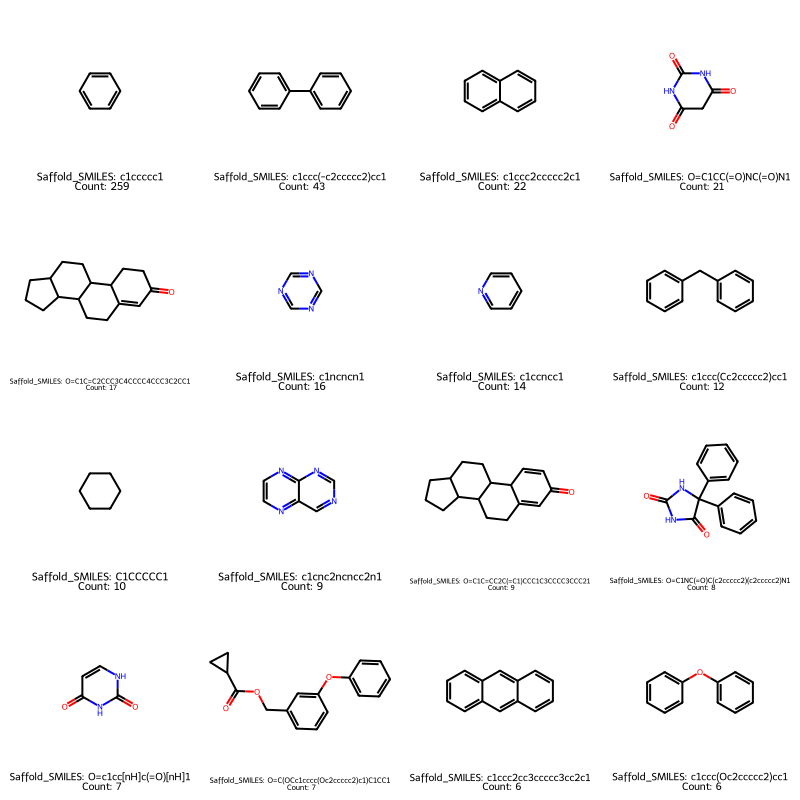

In [11]:
# display the top 16 scaffolds in a grid
top_scaffolds = scaffolds.filter(scaffolds != "No_Scaffold").value_counts(sort=True)[:16]
top_scaffolds_smiles = top_scaffolds['Saffold_SMILES']
top_scaffolds_mols = [rdkit.Chem.MolFromSmiles(smi) for smi in top_scaffolds_smiles]
top_scaffolds_counts = top_scaffolds['count']  

MolsToGridImage(top_scaffolds_mols, molsPerRow=4, subImgSize=(200, 200), 
                legends=[f'Saffold_SMILES: {smi}\n Count: {count}' for smi, count in zip(top_scaffolds_smiles, top_scaffolds_counts)])
